In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('../../data/train.csv').drop(columns=['ID'])
test = pd.read_csv('../../data/test.csv').drop(columns=['ID'])

In [2]:
train_X = train.drop(columns=['y'])
train_y = train['y']

In [3]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import boxcox

def trf(data,name,offset):
    
    # step1 : minmax 수행 (boxcox는 양수여야 할 수 있음)
    scaler = MinMaxScaler() 
    scaled_data = pd.DataFrame(scaler.fit_transform(data),columns=data.columns)
    
    # step2 : boxcox 수행
    new_data = pd.DataFrame()
    for col in scaled_data.columns:
        adjusted_data = scaled_data[col]+offset
        new_data[col], _ = boxcox(adjusted_data)

    globals()[f'trf_{name}'] = new_data 
    
    return new_data
    
trf(train_X, 'train',1e-5)
trf(test, 'test',1e-5)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,-0.201194,-1.168740,-0.120100,-0.293759,-0.042170,-2.333110,-2.221613,-0.709142,-0.613398,-0.718081,-0.077710
1,-0.190676,-2.912906,-0.433474,-0.591735,-0.073514,-1.740999,-1.012437,-1.314374,-0.047021,-1.476682,-0.064796
2,-0.568275,-0.277103,-0.394133,-0.068057,-0.311416,-0.388553,-0.745910,-0.157155,-1.235607,-0.216321,-0.399962
3,-0.568762,-0.160616,-0.482380,-0.220966,-0.338134,-0.235169,-0.481629,-0.083864,-1.260787,-0.158543,-0.434785
4,-0.201681,-2.073343,-0.353514,-0.463317,-0.080793,-1.957596,-0.955016,-1.208936,-0.075601,-1.484767,-0.048458
...,...,...,...,...,...,...,...,...,...,...,...
4981,-0.339090,-1.219143,-0.083330,-0.448500,-0.025652,-2.911363,-1.880823,-0.752386,-0.553524,-0.796050,-0.063371
4982,-0.701362,-0.147968,-0.479195,-0.038093,-0.343581,-0.227439,-0.448576,-0.098271,-1.205667,-0.159778,-0.435263
4983,-0.136137,-1.895324,-0.186558,-0.491578,-0.010898,-3.514671,-1.484669,-0.931317,-0.322627,-0.938112,-0.019113
4984,-0.186621,-1.922590,-0.092088,-0.358693,-0.023077,-3.252352,-1.544006,-0.852904,-0.267710,-1.031831,-0.004700


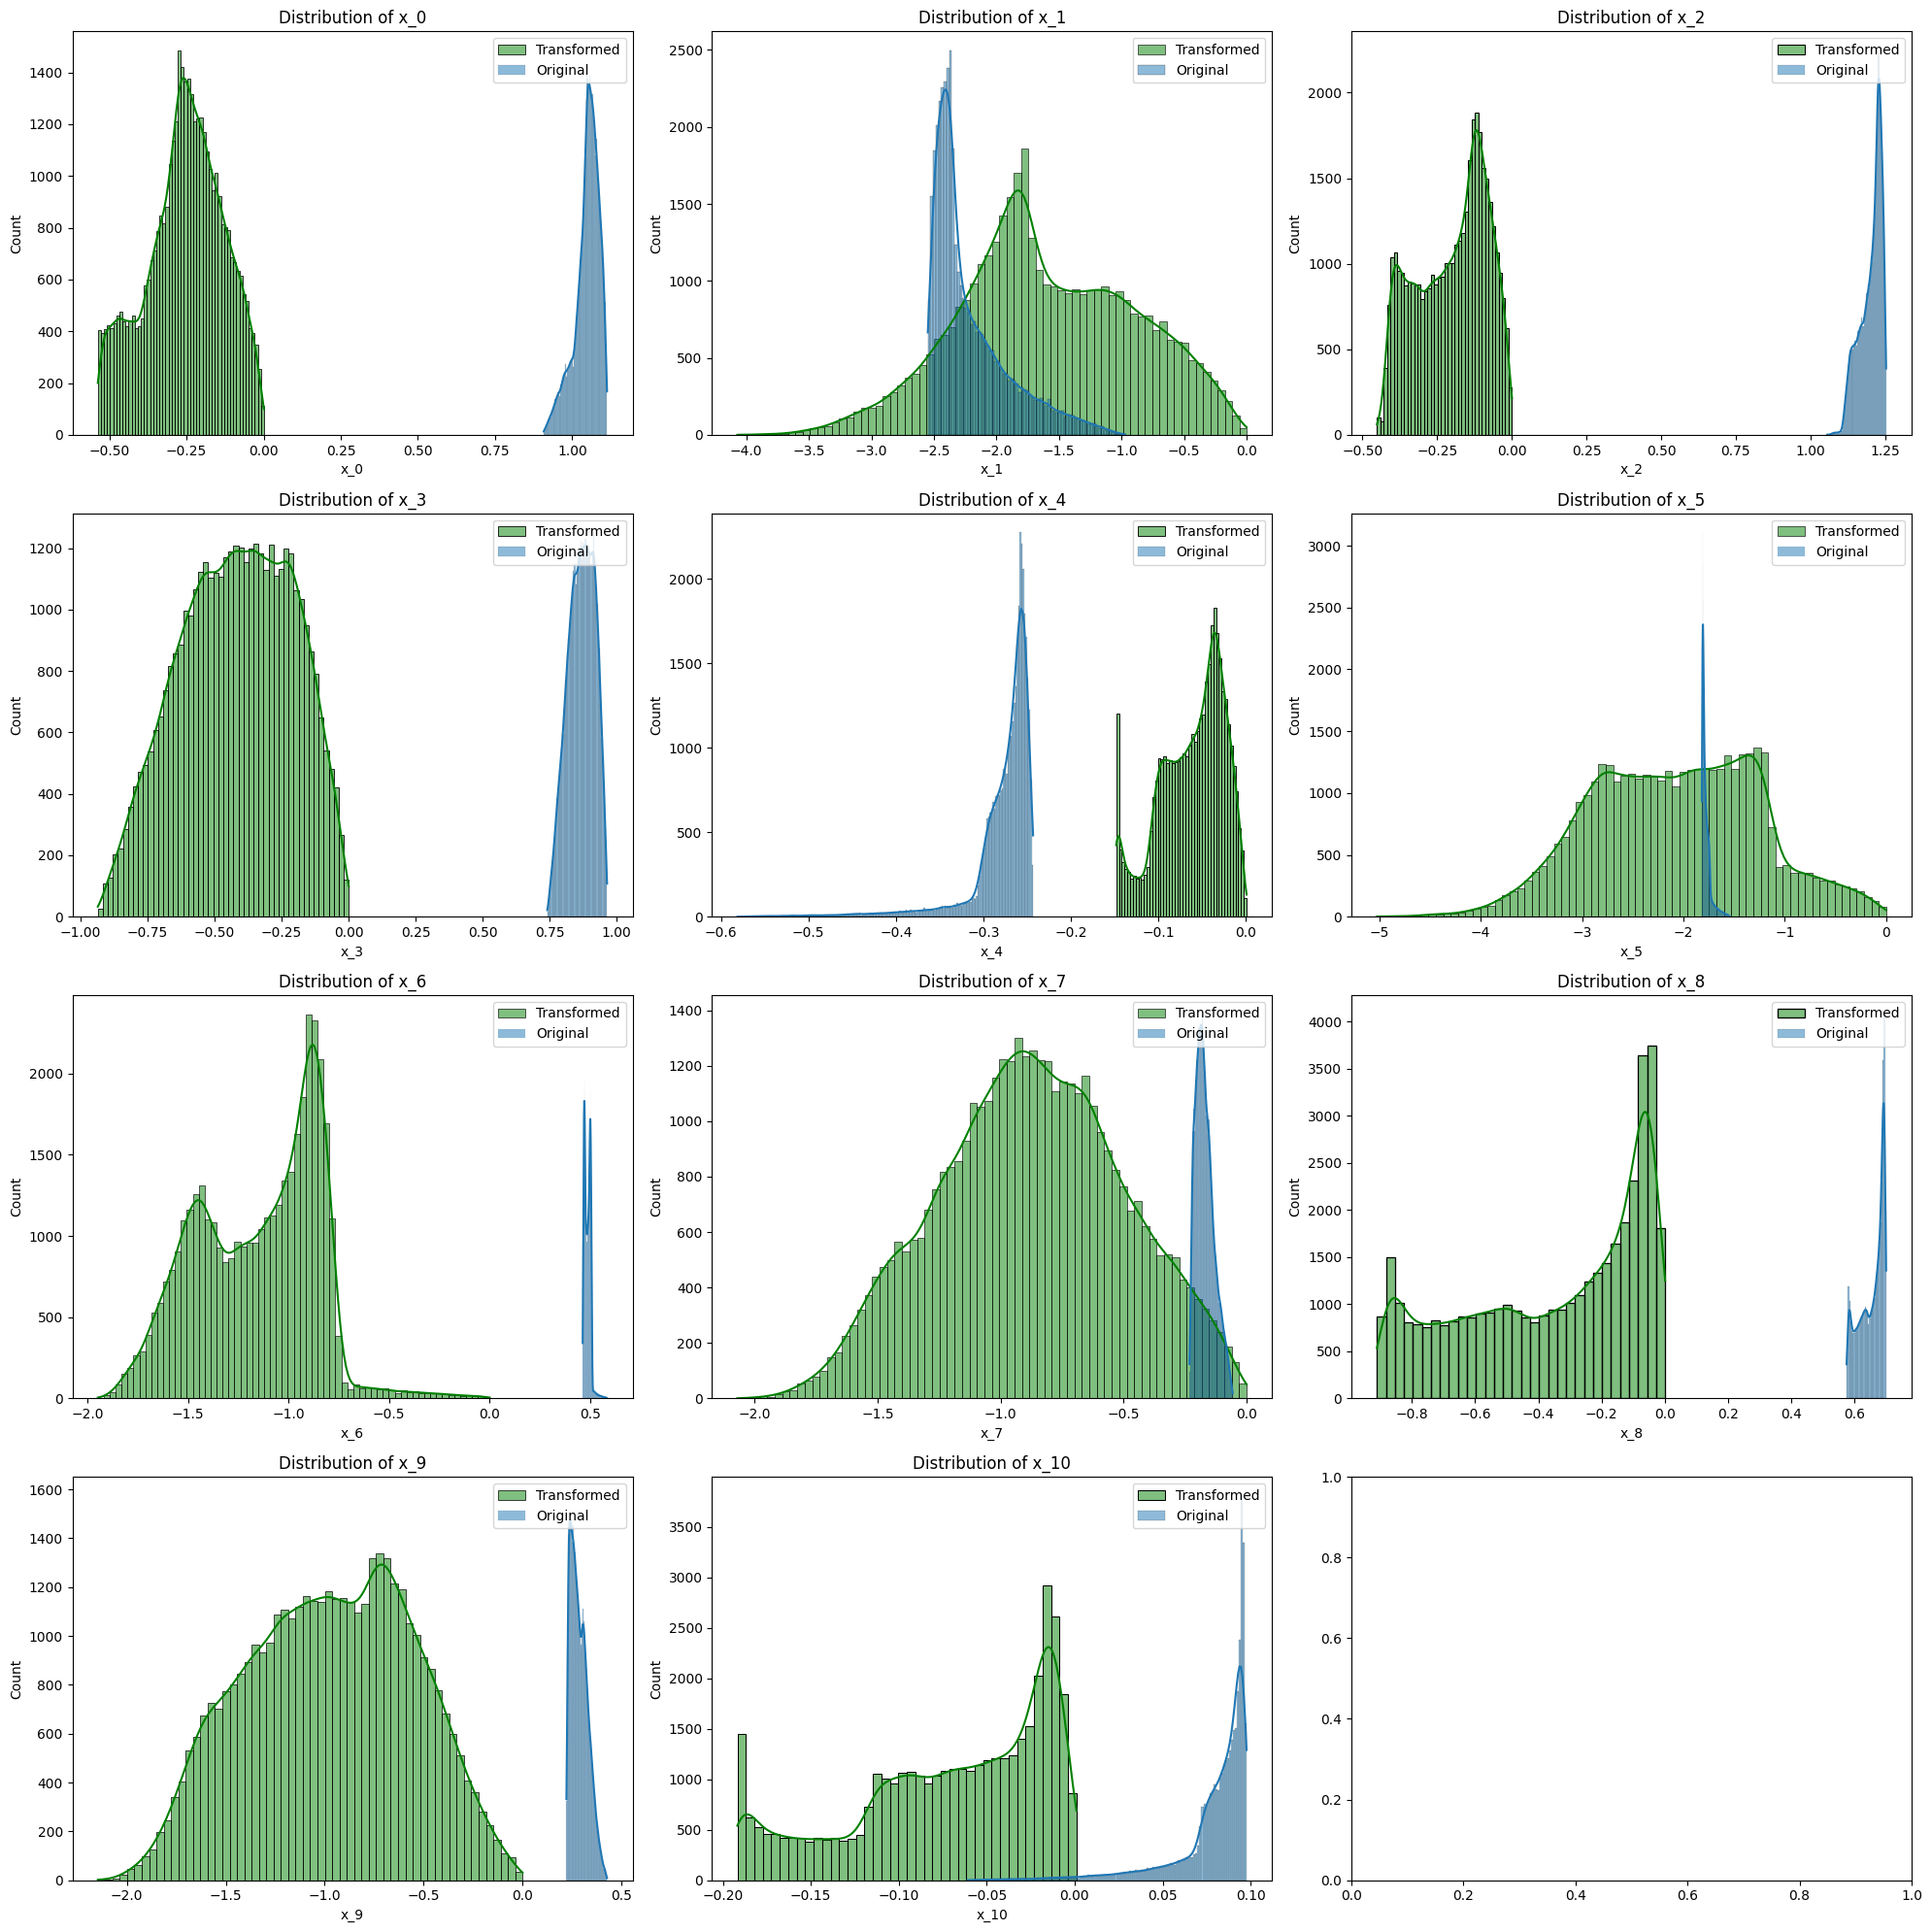

In [4]:
# 시각화
fig,axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel()

for i, col in enumerate(trf(train_X, 'train',1e-3).columns):
    sns.histplot(trf(train_X, 'train',1e-3)[col],ax=axes[i],kde=True, label='Transformed', color='green')
    sns.histplot(train_X[col],ax=axes[i], kde=True, label='Original')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()

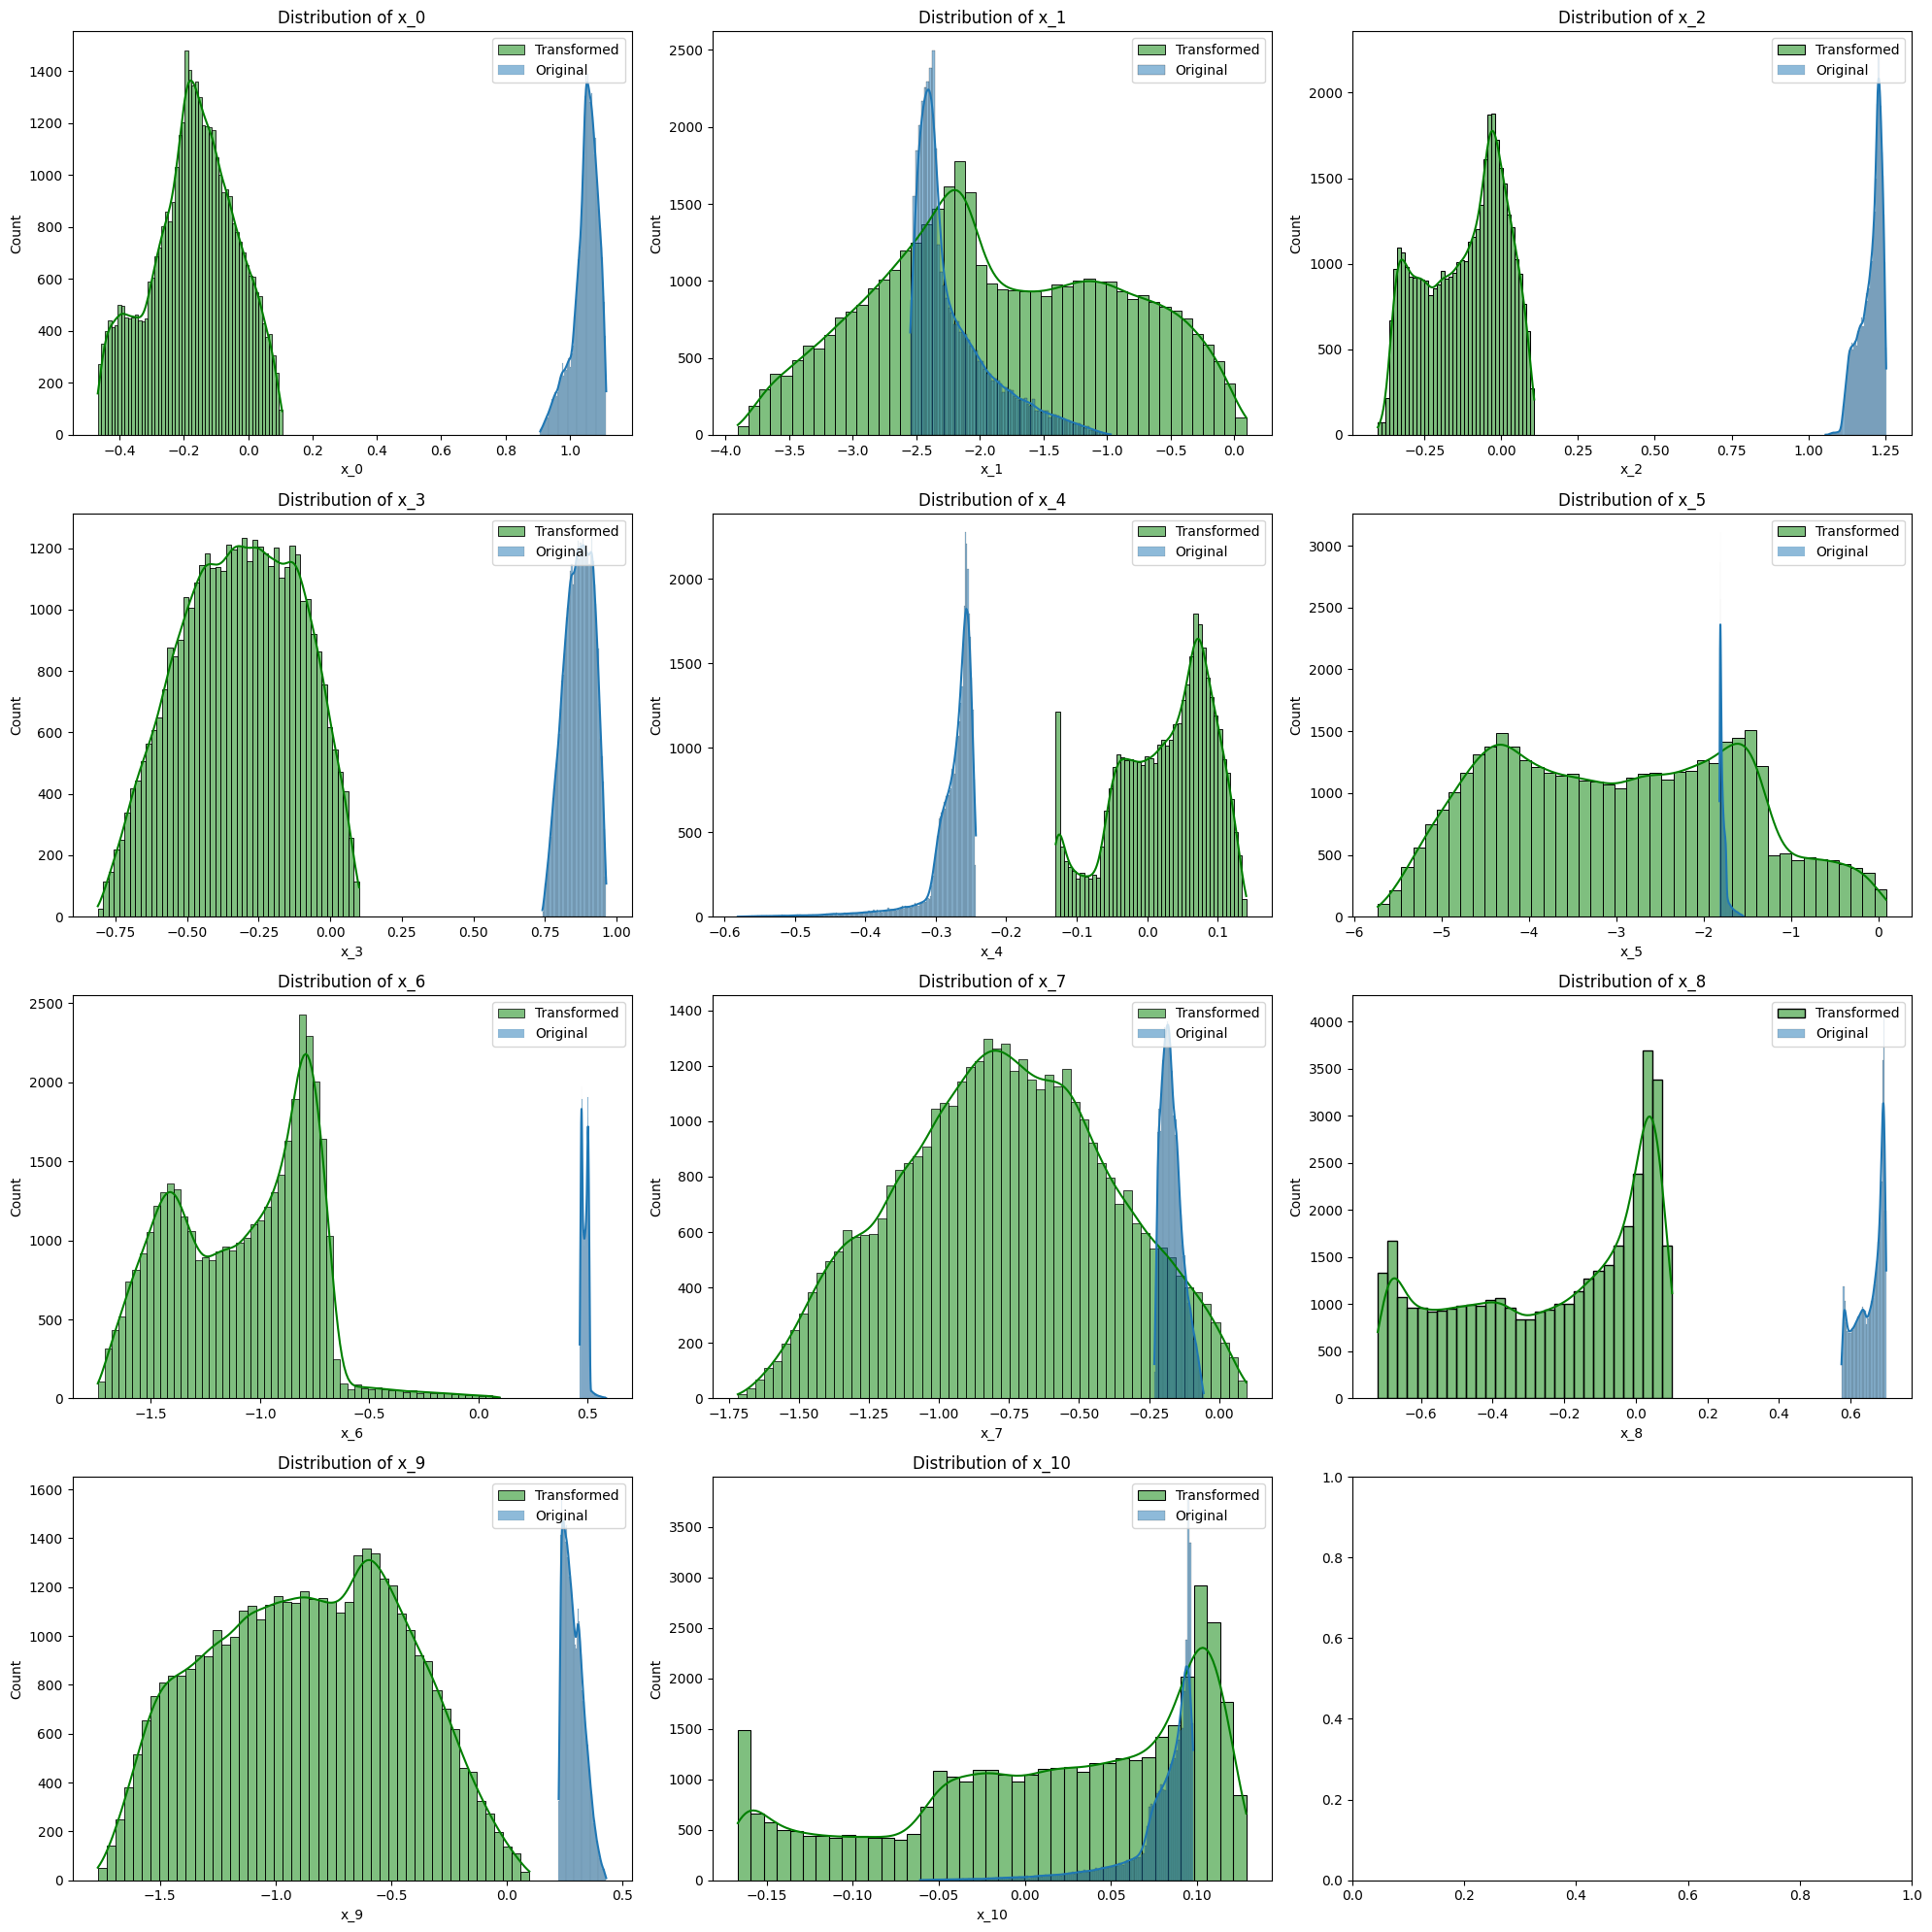

In [5]:
# 시각화
fig,axes = plt.subplots(4,3,figsize=(20,20))
axes = axes.ravel()

for i, col in enumerate(trf(train_X, 'train',1e-1).columns):
    sns.histplot(trf(train_X, 'train',1e-1)[col],ax=axes[i],kde=True, label='Transformed', color='green')
    sns.histplot(train_X[col],ax=axes[i], kde=True, label='Original')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()

offset 값에 따라 조정되는 경향이 아주 미세하게 달라짐

근데 뭐가 optimal한 값인지 모르겠음...ㅠㅠ

그냥 다른 transformation도 다양하게 적용해봐야 할 것 같음

### 그냥 AutoML 돌려보자

In [6]:
from pycaret.regression import setup, compare_models, pull, save_model, load_model, predict_model

train_data = pd.concat([trf(train_X, 'train',1e-1), train_y], axis=1)

regressor = setup(data = train_data, target='y', session_id=42)
best_model = compare_models()
results = pull()

results

,Description,Value
0,Session id,42
1,Target,y
2,Target type,Regression
3,Original data shape,"(40118, 12)"
4,Transformed data shape,"(40118, 12)"
5,Transformed train set shape,"(28082, 12)"
6,Transformed test set shape,"(12036, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.2080,2.8842,1.6898,0.6045,0.0220,0.0146,2.5850
lightgbm,Light Gradient Boosting Machine,1.2124,2.8976,1.6941,0.6025,0.0220,0.0147,0.3970
ridge,Ridge Regression,1.2252,2.9306,1.7035,0.5981,0.0222,0.0148,0.0200
br,Bayesian Ridge,1.2251,2.9304,1.7034,0.5981,0.0222,0.0148,0.0170
lr,Linear Regression,1.2250,2.9303,1.7034,0.5981,0.0222,0.0148,0.4020
lar,Least Angle Regression,1.2261,2.9354,1.7049,0.5974,0.0222,0.0149,0.0110
et,Extra Trees Regressor,1.2348,2.9776,1.7173,0.5915,0.0223,0.0150,1.5580
rf,Random Forest Regressor,1.2356,2.9917,1.7214,0.5896,0.0224,0.0150,6.1110
huber,Huber Regressor,1.2312,2.9914,1.7216,0.5895,0.0223,0.0149,0.1700
knn,K Neighbors Regressor,1.3340,3.4490,1.8508,0.5257,0.0238,0.0161,0.0220


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1.2080,2.8842,1.6898,0.6045,0.0220,0.0146,2.585
lightgbm,Light Gradient Boosting Machine,1.2124,2.8976,1.6941,0.6025,0.0220,0.0147,0.397
ridge,Ridge Regression,1.2252,2.9306,1.7035,0.5981,0.0222,0.0148,0.020
br,Bayesian Ridge,1.2251,2.9304,1.7034,0.5981,0.0222,0.0148,0.017
lr,Linear Regression,1.2250,2.9303,1.7034,0.5981,0.0222,0.0148,0.402
lar,Least Angle Regression,1.2261,2.9354,1.7049,0.5974,0.0222,0.0149,0.011
et,Extra Trees Regressor,1.2348,2.9776,1.7173,0.5915,0.0223,0.0150,1.558
rf,Random Forest Regressor,1.2356,2.9917,1.7214,0.5896,0.0224,0.0150,6.111
huber,Huber Regressor,1.2312,2.9914,1.7216,0.5895,0.0223,0.0149,0.170
knn,K Neighbors Regressor,1.3340,3.4490,1.8508,0.5257,0.0238,0.0161,0.022


In [7]:
save_model(best_model, 'best_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['x_0', 'x_1', 'x_2', 'x_3', 'x_4',
                                              'x_5', 'x_6', 'x_7', 'x_8', 'x_9',
                                              'x_10'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('trained_model', GradientBoostingRegressor(random_state=42))]),
 'best_model.pkl')

In [8]:
best_model = load_model('best_model')
preds = predict_model(best_model, data = trf(test, 'test',1e-3))

preds

Transformation Pipeline and Model Successfully Loaded


,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,prediction_label
0,-0.201194,-1.168740,-0.120100,-0.293759,-0.042170,-2.333110,-2.221613,-0.709142,-0.613398,-0.718081,-0.077710,85.732357
1,-0.190676,-2.912906,-0.433474,-0.591735,-0.073514,-1.740999,-1.012437,-1.314374,-0.047021,-1.476682,-0.064796,80.952204
2,-0.568275,-0.277103,-0.394133,-0.068057,-0.311416,-0.388553,-0.745910,-0.157155,-1.235607,-0.216321,-0.399962,88.117175
3,-0.568762,-0.160616,-0.482380,-0.220966,-0.338134,-0.235169,-0.481629,-0.083864,-1.260787,-0.158543,-0.434785,87.859455
4,-0.201681,-2.073343,-0.353514,-0.463317,-0.080793,-1.957596,-0.955016,-1.208936,-0.075601,-1.484767,-0.048458,81.728685
...,...,...,...,...,...,...,...,...,...,...,...,...
4981,-0.339090,-1.219143,-0.083330,-0.448500,-0.025652,-2.911363,-1.880823,-0.752386,-0.553524,-0.796050,-0.063371,84.645424
4982,-0.701362,-0.147968,-0.479195,-0.038093,-0.343581,-0.227439,-0.448576,-0.098271,-1.205667,-0.159778,-0.435263,87.074972
4983,-0.136137,-1.895324,-0.186558,-0.491578,-0.010898,-3.514671,-1.484669,-0.931317,-0.322627,-0.938112,-0.019113,82.649969
4984,-0.186621,-1.922590,-0.092088,-0.358693,-0.023077,-3.252352,-1.544006,-0.852904,-0.267710,-1.031831,-0.004700,82.793446


In [10]:
submission = pd.read_csv('../../data/sample_submission.csv')
submission['y'] = preds['prediction_label']
submission.to_csv('../boxcox/boxcox_submission.csv',index=False)